# CSGY 6953 Deep Learning Final Project
In this project, we will implement a dual-encoder model for image search. In particular, our model will be fed a text query and will return several images that are related to the query. To do this task, our model will be trained so that it embeds both image and text data into the same space, and importantly, encodes relevant data to be close each other in the embedding space. This will be done by developing two encoders, one for image processing and the other for text encoding, and training them by a similarity-based loss function. 

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
import random
import tqdm
import math

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
with open(f"drive/My Drive/finalproj/data/dataset.pkl", "rb") as f:
    dataset = pickle.load(f)

In [4]:
train_pct = 0.7
threshold = int(len(dataset["images"]) * train_pct)
train_images = dataset["images"][:threshold]
train_texts = dataset["texts"][:threshold * 10]
test_images = dataset["images"][threshold:]
test_texts = dataset["texts"][threshold * 10:]
print(f"Training images: ", len(train_images))
print(f"Training texts: ", len(train_texts))
print(f"Test images: ", len(test_images))
print(f"Test texts: ", len(test_texts))

Training images:  3150
Training texts:  31500
Test images:  1350
Test texts:  13500


In [49]:
import torch
from torch.utils.data import Dataset, DataLoader
import torchvision
!pip install transformers
from transformers import BertModel, BertTokenizerFast
!pip install timm
import timm

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 549 kB 13.5 MB/s 


In [6]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("The device is " + device.type + ".")

The device is cuda.


## Encoders
Encoders denote the pretrained part of the network. In both image and text encoders, they returns an 1-D array. This is fed into fully connected layers having trainable parameters before computing the similarity. This FC layers will be defined separately, which we call Encoder Head. <br>
<br>
Encoder class must have
* Pretrained model and forward function.
* self.output_size: the size of the 1-D array. (This may be a tuple in the later step when we fine-tune the output of the language models.)
* self.num_parameters: This is not necessary but we store the number of pretrained parameters here.

In [64]:
class InceptionV3Encoder(torch.nn.Module):
    def __init__(self):
        super(InceptionV3Encoder, self).__init__()

        self.incep3 = torchvision.models.inception_v3(pretrained=True)
        self.incep3.aux_logits = False # We don't use the auxiliary output.
        self.output_size = self.incep3.fc.in_features # in_features=2048.
        self.incep3.fc = torch.nn.Identity() # Deactivate the fc layer. torch.nn.Identity has no parameters.
        for parameter in self.incep3.parameters():
            parameter.requires_grad = False # Freeze all the parameters.
        self.num_parameters = sum([np.prod(params.size()) for params in self.incep3.parameters()])

    def forward(self, x):
        return self.incep3(x)

class XceptionEncoder(torch.nn.Module):
    def __init__(self):
        super(XceptionEncoder, self).__init__()

        self.xception = timm.create_model("xception", pretrained=True)
        self.output_size = self.xception.fc.in_features
        self.xception.fc = torch.nn.Identity()
        for parameter in self.xception.parameters():
            parameter.requires_grad = False
        self.num_parameters = sum([np.prod(params.size()) for params in self.xception.parameters()])
    
    def forward(self, x):
        return self.xception(x)

class ResNetEncoder(torch.nn.Module):
    def __init__(self):
        super(ResNetEncoder, self).__init__()

        self.resnet = torchvision.models.resnet101(pretrained=True, progress=False)
        self.output_size = self.resnet.fc.in_features
        self.resnet.fc = torch.nn.Identity()
        for parameter in self.resnet.parameters():
            parameter.requires_grad = False
        self.num_parameters = sum([np.prod(params.size()) for params in self.resnet.parameters()])
    
    def forward(self, x):
        return self.resnet(x)

class BertEncoder(torch.nn.Module):
    def __init__(self):
        super(BertEncoder, self).__init__()

        self.bert = BertModel.from_pretrained("bert-base-uncased", output_attentions=False) # With bert-base-uncased, all the input are lowercased before being tokenized.
        self.output_size = self.bert.config.hidden_size # hidden_size=768.
        for parameter in self.bert.parameters():
            parameter.requires_grad = False # Freeze all the parameters.
        self.num_parameters = sum([np.prod(params.size()) for params in self.bert.parameters()])
    
    def forward(self, input_ids, attention_mask):
        last_hidden, _ = self.bert(input_ids=input_ids, attention_mask=attention_mask, return_dict=False)
        return last_hidden[:, 0]




def Encoder(name):
    if name == "InceptionV3":
        return InceptionV3Encoder()
    elif name == "Xception":
        return XceptionEncoder()
    elif name == "ResNet":
        return ResNetEncoder()
    elif name == "BERT":
        return BertEncoder()
    elif name == "BERT_word2vec":
        return BertWord2VecEncoder()
    else:
        raise ValueError(name + " has not been implemented!")

## Encoder Head
Encoder Heads are defined as follows. While our Encoders have only pretrained parameters, which are freezed during the training, all the parameters in Encoder Heads are trainable. Usually, they consists of one or more fully connected layers. <br>
<br>
Encoder Head class must have
* Trainable model and forward function.
* self.num_parameters: This is not necessary but we store the number of trainable parameters here.

In [8]:
class EncoderHead1(torch.nn.Module):
    def __init__(self, input_dim, embed_dim=128):
        super(EncoderHead1, self).__init__()

        self.fc = torch.nn.Sequential(
            torch.nn.Linear(input_dim, 512),
            torch.nn.ReLU(),
            torch.nn.Linear(512, embed_dim),
            torch.nn.Tanh()
        )
        self.num_parameters = sum([np.prod(params.size()) for params in self.fc.parameters()])

    def forward(self, x):
        return self.fc(x)

def EncoderHead(name, input_dim, embed_dim=128):
    if name == "normal_1":
        return EncoderHead1(input_dim, embed_dim)

## Preprocessors
The original dataset has lists of numbers and texts. To feed them into our Encoders, we need to preprocess them into the required form. This work is done by Preprocessors.

In [65]:
class ImagePreprocessor():
    def process(self, x):
        return torch.swapaxes(torch.swapaxes(x / 255.0, 3, 2), 2, 1)

class BertPreprocessor():
    def __init__(self, max_len=50):
        self.max_len = max_len
        self.tokenizer = BertTokenizerFast.from_pretrained("bert-base-uncased", model_max_length=self.max_len)
    
    def process(self, x):
        padded_list = self.tokenizer.batch_encode_plus(x, padding=True)
        input_ids = torch.LongTensor(np.array(padded_list["input_ids"])) # It looks like bypassing numpy is faster.
        attention_mask = torch.LongTensor(np.array(padded_list["attention_mask"]))
        return input_ids, attention_mask

class GloVePreprocessor():
    def __init__(self, max_len=50):
        self.max_len = max_len

        


def Preprocessor(name, max_len=70):
    if name in ["InceptionV3", "Xception", "ResNet"]:
        return ImagePreprocessor()
    elif name in ["BERT"]:
        return BertPreprocessor(max_len)
    else:
        raise ValueError(name + " has not been implemented!")

In [111]:
with open('glove.6B.50d.txt','rt') as fi:
    full_content = fi.read().strip().split('\n')

## Dataset 
To use the DataLoader, we need the following DualEncoderDataset class. It does
* Preprocess the data and store the output of Encoders.
* Create the positive and negative pairs of an image and a text.
* neg_rate controls the rate of negative pairs. For each positive pair, it generates neg_rate negative pairs.

In [66]:
class DualEncoderDataset(Dataset):
    def __init__(self, images, texts, device, image_model, text_model, max_len=70, neg_rate=4, preprocessing_batch_size=32):
        self.num_images = len(images)
        self.num_texts = len(texts)
        self.image_text_rate = int(self.num_texts / self.num_images)
        self.num_negative = int(self.num_texts * neg_rate)
        self.random_map = []
        self.shuffle()

        print("\nPreprocessing image data...")
        self.imagedata_preprocessed = []
        image_encoder = Encoder(image_model).to(device)
        image_preprocessor = Preprocessor(image_model)
        num_batches = math.ceil(self.num_images / preprocessing_batch_size)
        for i in tqdm.tqdm(range(num_batches)):
            if i < num_batches - 1:
                image_batch = images[i * preprocessing_batch_size : (i + 1) * preprocessing_batch_size]
            else:
                image_batch = images[i * preprocessing_batch_size :]
            image_batch = torch.FloatTensor(np.array(image_batch)).to(device)
            self.imagedata_preprocessed += image_encoder(image_preprocessor.process(image_batch)).tolist()
        self.image_encoder_num_parameters = image_encoder.num_parameters
        self.image_encoder_output_size = image_encoder.output_size

        print("Preprocessing text data...")
        self.textdata_preprocessed = []
        text_encoder = Encoder(text_model).to(device)
        text_preprocessor = Preprocessor(text_model, max_len)
        num_batches = math.ceil(self.num_texts / preprocessing_batch_size)
        for i in tqdm.tqdm(range(num_batches)):
            if i < num_batches - 1:
                text_batch = texts[i * preprocessing_batch_size : (i + 1) * preprocessing_batch_size]
            else:
                text_batch = texts[i * preprocessing_batch_size :]
            text_batch, attention_batch = text_preprocessor.process(text_batch)
            text_batch = text_batch.to(device)
            if attention_batch is not None:
                attention_batch = attention_batch.to(device)
                self.textdata_preprocessed += text_encoder(text_batch, attention_batch).tolist()
            else:
                self.textdata_preprocessed += text_encoder(text_batch).tolist()
        self.text_encoder_num_parameters = text_encoder.num_parameters
        self.text_encoder_output_size = text_encoder.output_size

    def shuffle(self):
        self.random_map = np.random.randint(0, self.num_texts - self.image_text_rate, self.num_negative)
        for i in range(self.num_negative):
            if self.random_map[i] >= i % self.num_texts // self.image_text_rate * self.image_text_rate:
                self.random_map[i] += self.image_text_rate
    
    def set_neg_rate(self, neg_rate):
        self.num_negative = int(self.num_texts * neg_rate)
        self.random_map = []
        self.shuffle()
    
    def print_num_params(self):
        print(f"\n=== Image Encoder ===")
        print(f"  Pretrained Parameters: {self.image_encoder_num_parameters:,}")
        print(f"\n=== Text Encoder ===")
        print(f"  Pretrained Parameters: {self.text_encoder_num_parameters:,}")
    
    def __len__(self):
        return self.num_texts + self.num_negative

    def __getitem__(self, sample_idx):
        if torch.is_tensor(sample_idx):
            sample_idx = sample_idx[0].tolist()
        image_idx = sample_idx % self.num_texts // self.image_text_rate
        image = self.imagedata_preprocessed[image_idx]
        image = torch.from_numpy(np.array(image)).to(torch.float32)

        if sample_idx < self.num_texts:
            text_idx = sample_idx
        else:
            text_idx = self.random_map[sample_idx - self.num_texts]
        text = self.textdata_preprocessed[text_idx]
        text = torch.from_numpy(np.array(text)).to(torch.float32)
        
        label = 1 if sample_idx < self.num_texts else -1
        label = torch.from_numpy(np.array(label)).to(torch.float32)

        sample = {"images": image, "texts": text, "labels": label, "image_idx": image_idx, "text_idx": text_idx}
        return sample

## Constructing Dataset
Set the parameters; embed_dim is the dimensionality of the embedding space, and max_len is the maximum length of the encoded text sequence. It takes time to construct the dataset because preprocessing and feed forwarding the pretrained nets are performed.

In [68]:
embed_dim = 256
max_len = 70
image_encoder_model = "ResNet"
text_encoder_model = "BERT"
image_head_model = "normal_1"
text_head_model = "normal_1"

TrainingDataset = DualEncoderDataset(train_images, train_texts, device, image_encoder_model, text_encoder_model, max_len=max_len, neg_rate=4)
TestDataset = DualEncoderDataset(test_images, test_texts, device, image_encoder_model, text_encoder_model, max_len=max_len, neg_rate=4)
TrainingDataset.print_num_params()


Preprocessing image data...


/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet101_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet101_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet101-63fe2227.pth" to /root/.cache/torch/hub/checkpoints/resnet101-63fe2227.pth
100%|██████████| 99/99 [00:33<00:00,  2.94it/s]


Preprocessing text data...


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.decoder.weight', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
100%|██████████| 985/985 [00:50<00:00, 19.68it/s]



Preprocessing image data...


100%|██████████| 43/43 [00:15<00:00,  2.80it/s]


Preprocessing text data...


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.decoder.weight', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
100%|██████████| 422/422 [00:21<00:00, 19.62it/s]


=== Image Encoder ===
  Pretrained Parameters: 42,500,160

=== Text Encoder ===
  Pretrained Parameters: 109,482,240


## Encoder Heads, Loss Function, Optimizer
Recall that all the trainable parameters reside in Encoder Heads. We also set the loss function and optimizer for each Encoder Head.

In [69]:
image_head = EncoderHead(image_head_model, TrainingDataset.image_encoder_output_size, embed_dim).to(device)
text_head = EncoderHead(text_head_model, TrainingDataset.text_encoder_output_size, embed_dim).to(device)
print(f"=== Image Encoder Head ===")
print(f"  Trainable Parameters: {image_head.num_parameters:,}")
print(f"\n=== Text Encoder Head ===")
print(f"  Trainable Parameters: {text_head.num_parameters:,}")

criterion = torch.nn.CosineEmbeddingLoss(margin=0.1, reduction='sum') # Recipe 1M+ paper sets margin=0.1.
image_optimizer = torch.optim.Adam(image_head.parameters(), lr=0.0005)
text_optimizer = torch.optim.Adam(text_head.parameters(), lr=0.0005)

=== Image Encoder Head ===
  Trainable Parameters: 1,180,416

=== Text Encoder Head ===
  Trainable Parameters: 525,056


## Training Function
Training and evaluation functions. As we set the CosineEmbeddingLoss with reduction="sum", all the loss are aggregated and divided by the number of samples at the end. <br>
With our naive algorithm to compute the Median Rank (MedR) and Recall at top K (R@K), it takes time to evaluate them. By setting only_loss=True, which is the default setting, we can skip the heavy load of computing MedR and R@K. <br>
sim_mat stores the cosine similarity between all the image-text pairs. It has a shape (# images * # texts).

In [70]:
def train():
    image_head.train()
    text_head.train()
    train_loss = 0
    num_samples = 0

    for batch in trainloader:
        image_optimizer.zero_grad()
        text_optimizer.zero_grad()
        image_embedding = image_head(batch["images"].to(device))
        text_embedding = text_head(batch["texts"].to(device))
        loss = criterion(image_embedding, text_embedding, batch["labels"].to(device))
        loss.backward()
        image_optimizer.step()
        text_optimizer.step()
        train_loss += loss.item()
        num_samples += batch["labels"].size(0)
    
    train_loss /= num_samples
    return train_loss

def eval(only_loss=True):
    image_head.eval()
    text_head.eval()
    eval_loss = 0
    num_samples = 0
    image_embeddings = [None for _ in range(TestDataset.num_images)]
    text_embeddings = [None for _ in range(TestDataset.num_texts)]
    with torch.no_grad():
        for batch in testloader:
            image_embedding = image_head(batch["images"].to(device))
            text_embedding = text_head(batch["texts"].to(device))
            for i in range(len(batch["image_idx"])):
                if image_embeddings[batch["image_idx"][i]] is None:
                    image_embedding_numpy = image_embedding[i].cpu().numpy()
                    image_embeddings[batch["image_idx"][i]] = image_embedding_numpy / np.linalg.norm(image_embedding_numpy, ord=2)
            for i in range(len(batch["text_idx"])):
                if text_embeddings[batch["text_idx"][i]] is None:
                    text_embedding_numpy = text_embedding[i].cpu().numpy()
                    text_embeddings[batch["text_idx"][i]] = text_embedding_numpy / np.linalg.norm(text_embedding_numpy, ord=2)
            loss = criterion(image_embedding, text_embedding, batch["labels"].to(device))
            eval_loss += loss.item()
            num_samples += batch["labels"].size(0)
    eval_loss /= num_samples

    if only_loss:
        sim_mat = np.zeros((TestDataset.num_images, TestDataset.num_texts))
    else: 
        image_embeddings = np.array(image_embeddings)
        text_embeddings = np.array(text_embeddings)
        sim_mat = np.dot(image_embeddings, text_embeddings.T)
    return eval_loss, sim_mat

In [71]:
def getMedR(sim_mat):
    rank = np.argsort(-sim_mat, axis=0)
    rank = np.argsort(rank, axis=0)
    ranking = [rank[i, i * TestDataset.image_text_rate : (i + 1) * TestDataset.image_text_rate] for i in range(TestDataset.num_images)]
    ranking = np.array(ranking).flatten()
    image_MedR = np.median(ranking)
    rank = np.argsort(-sim_mat, axis=1)
    rank = np.argsort(rank, axis=1)
    ranking = [rank[i, i * TestDataset.image_text_rate : (i + 1) * TestDataset.image_text_rate] for i in range(TestDataset.num_images)]
    ranking = np.array(ranking).flatten()
    text_MedR = np.median(ranking)
    return {"image": image_MedR, "text": text_MedR}

def getRatK(sim_mat, K=10):
    rank = np.argsort(-sim_mat, axis=0)
    rank = np.argsort(rank, axis=0)
    ranking = [rank[i, i * TestDataset.image_text_rate : (i + 1) * TestDataset.image_text_rate] for i in range(TestDataset.num_images)]
    ranking = np.array(ranking).flatten()
    image_RatK = sum(ranking < K) / len(ranking)
    rank = np.argsort(-sim_mat, axis=1)
    rank = np.argsort(rank, axis=1)
    ranking = [rank[i, i * TestDataset.image_text_rate : (i + 1) * TestDataset.image_text_rate] for i in range(TestDataset.num_images)]
    ranking = np.array(ranking).flatten()
    text_RatK = sum(ranking < K) / len(ranking)
    return {"image": image_RatK, "text": text_RatK}

In [72]:
epochs = 10
batch_size = 128
train_loss = []
eval_loss = []
trainloader = DataLoader(TrainingDataset, batch_size=batch_size, shuffle=True)
testloader = DataLoader(TestDataset, batch_size=batch_size, shuffle=True)

print("Start Training...")
for epoch in range(epochs):
    trainloss = train()
    train_loss.append(trainloss)
    evalloss, _ = eval()
    eval_loss.append(evalloss)
    if (epoch + 1) % 2 == 0:
        print("Epoch: " + str(epoch + 1) + " | Training loss: " + str(round(trainloss, 4)) + " | Test loss: " + str(round(evalloss, 4)))
    # if (epoch + 1) % 4 == 0:
    #     TrainingDataset.shuffle()
    #     trainloader = DataLoader(TrainingDataset, batch_size=batch_size, shuffle=True)
    #     print("   Negative pairs shuffled after epoch " + str(epoch + 1))
_, sim_mat = eval(only_loss=False)

Start Training...
Epoch: 2 | Training loss: 0.1485 | Test loss: 0.1351


KeyboardInterrupt: ignored

Ideally in the heatmap, we want to have high values in diagonal entries and values less than margin (a parameter in CosineEmbeddingLoss) otherwise.

Image Retrieval From Text:
   Median Rank: 45.0 / 1350
   Recall at K: 0.177
Text Retrieval From Image:
   Median Rank: 457.0 / 13500
   Recall at K: 0.022


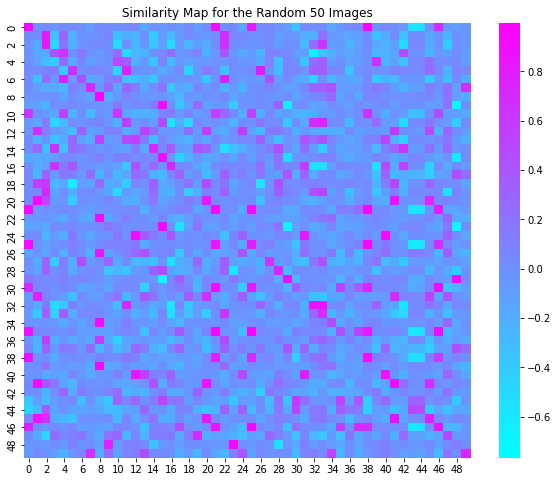

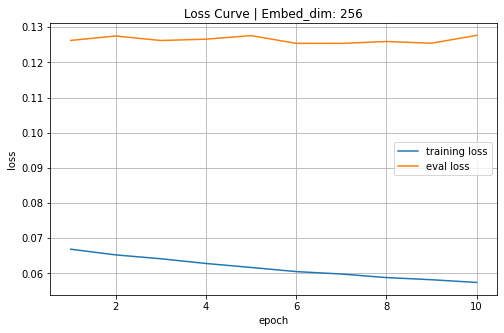

In [23]:
MedR = getMedR(sim_mat)
RatK = getRatK(sim_mat)
print("Image Retrieval From Text:")
print("   Median Rank: " + str(round(MedR["image"], 2)) + " / " + str(TestDataset.num_images))
print("   Recall at K: " + str(round(RatK["image"], 3)))
print("Text Retrieval From Image:")
print("   Median Rank: " + str(round(MedR["text"], 2)) + " / " + str(TestDataset.num_texts))
print("   Recall at K: " + str(round(RatK["text"], 3)))

num_show = 50
plt.figure(figsize=(10,8))
rand_idx = np.random.randint(0, len(sim_mat), num_show)
sns.heatmap(sim_mat[rand_idx][:, rand_idx * 10 + np.random.randint(0, 10, num_show)], cmap="cool")
plt.title("Similarity Map for the Random " + str(num_show) + " Images")
plt.show()

plt.figure(figsize=(8,5))
plt.plot(np.arange(1, epochs + 1), train_loss, label="training loss")
plt.plot(np.arange(1, epochs + 1), eval_loss, label="eval loss")
plt.title(f"Loss Curve | Embed_dim: {embed_dim}")
plt.xlabel("epoch")
plt.ylabel("loss")
plt.grid()
plt.legend()
plt.show()

In [46]:
def TextFromImage(sim_mat, num_image=5, num_text=10):
    image_idx = np.random.randint(0, TestDataset.num_images, num_image)
    rank = np.argsort(-sim_mat, axis=1)
    for i in range(num_image):
        print("Query Image:")
        img = test_images[image_idx[i]]
        img = np.flip(img, axis=-1)
        plt.figure(figsize=(3, 3))
        plt.imshow(img)
        plt.show()
        plt.figure(figsize=(15, 3))
        for j in range(num_text):
            print(f"CosSim={sim_mat[image_idx[i], rank[image_idx[i], j]]:.4f} | " + test_texts[rank[image_idx[i], j]])

def ImageFromText(sim_mat, num_text=5, num_image=10):
    text_idx = np.random.randint(0, TestDataset.num_texts, num_text)
    rank = np.argsort(-sim_mat, axis=0)
    for i in range(num_text):
        print("Query Text: " + test_texts[text_idx[i]])
        plt.figure(figsize=(20, 5))
        for j in range(num_image):
            plt.subplot(1, num_image, j + 1)
            img = test_images[rank[j, text_idx[i]]]
            img = np.flip(img, axis=-1)
            plt.imshow(img)
            plt.title(f"CosSim={sim_mat[rank[j, text_idx[i]], text_idx[i]]:.4f}")
        plt.tight_layout()
        plt.show()
        print("\n")

Query Image:


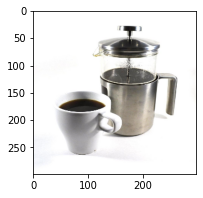

CosSim=0.9908 | A glass cup sitting under a coffee maker. 
CosSim=0.9901 | A coffee maker with a glass sitting on it.
CosSim=0.9892 | A black tea kettle with a white tea cup and saucer. 
CosSim=0.9877 | A bottle is held above a device to warm it up.
CosSim=0.9859 | Two beers are on a wooden table outside.
CosSim=0.9855 | Tray with a lamp and a picture of a woman wearing a dress holding a cigarette on it.
CosSim=0.9852 | A TAN TEAPOT SITTING NEXT TO A YELLOW CUP AND SAUCER.
CosSim=0.9850 | A piece of furniture in a corner of the room that is for alcohol.
CosSim=0.9844 | A large mug with a can of beer poured into it.
CosSim=0.9843 | A coffee pot is on a table next to a cup.
Query Image:


<Figure size 1080x216 with 0 Axes>

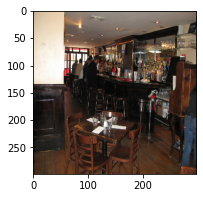

CosSim=0.9583 | A meeting room with table and chairs near an opened window.
CosSim=0.9526 | A large wide open areas with wooden waalls and leather couches.
CosSim=0.9497 | A dimly lit room with a bed, chair, and table.
CosSim=0.9490 | An office building has a waiting area with black furniture with large plants behind it and three tvs lined up on the wall.
CosSim=0.9453 | A room with several couches and chairs set up with a bar in the back.
CosSim=0.9376 | a large window covered by some sheer window dressings. There is a table and some chairs in front of it.
CosSim=0.9374 | Modern store where people are shopping with white fixtures.
CosSim=0.9280 | Three sofas are next to windows in a high end shopping area
CosSim=0.9259 | beige colored curtains and a long table surrounded by chairs.
CosSim=0.9248 | The inside of a restaurant with a television and video game.
Query Image:


<Figure size 1080x216 with 0 Axes>

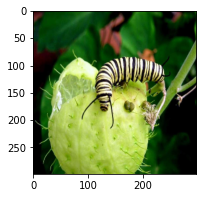

CosSim=0.9897 | A monkey is hanging from one of the trees.
CosSim=0.9897 | The woodpecker is on a tree branch next to the red flower.
CosSim=0.9896 | A beautiful dragonfly sitting on glass blade early morning with nice out of focus effect created by dew drops.
CosSim=0.9894 | A woodpecker standing next to a red flower.
CosSim=0.9893 | A bird perched on a branch in front of a red flower.
CosSim=0.9892 | A bees flying around purple flowers on a clear day.
CosSim=0.9890 | A yellow a black snake with orange eyes is crawling over some leaves.
CosSim=0.9888 | a bird is standing on a wood frame next to the plants.
CosSim=0.9883 | A black cricket on a green leaf. 
CosSim=0.9883 | The snake is waiting in the pile of dead leaves.
Query Image:


<Figure size 1080x216 with 0 Axes>

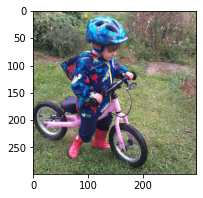

CosSim=0.9915 | A woman wearing a helmet is riding a bicycle down a road. 
CosSim=0.9914 | A person riding a bicycle with a child attachment on the back passes a person riding in a modified wheelchair.
CosSim=0.9878 | Man in bicycle riding gear riding bike down road next to a guardrail. 
CosSim=0.9876 | A man with a blue helmet rides a bike on grass.
CosSim=0.9867 | a cyclist in a red and black cycling shirt riding a bike
CosSim=0.9865 | A man wearing cycling clothes rides a recumbent bike. 
CosSim=0.9864 | A man wearing a helmet is riding on a reclining bicycle .
CosSim=0.9863 | A man in yellow and blue riding a motorcycle on grass. 
CosSim=0.9861 | A man in a helmet riding a bicycle holding on to the handles.
CosSim=0.9861 | A person on a dirt bike coming down a hill in a cloud of dust.
Query Image:


<Figure size 1080x216 with 0 Axes>

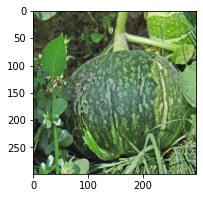

CosSim=0.8615 | A bunch of bees are on a honeycomb in a bee hive. 
CosSim=0.8381 | Three red apples lined up for a photo.
CosSim=0.8359 | Different kinds of plants sit inside a nursery.
CosSim=0.8258 | A pineapple that is ripe for picking from its plant outside. 
CosSim=0.8223 | A large bushel of grapes still on the vine.
CosSim=0.8198 | Row of red and green apples with stems removed. 
CosSim=0.8183 | The seeds of a cut small pumpkin are visible.
CosSim=0.8139 | A bunch of oranges piled up together. 
CosSim=0.8138 | An empty honeycomb with no use as a beehive.
CosSim=0.8123 | A collection of varieties of fruit of different types and colors 


<Figure size 1080x216 with 0 Axes>

In [44]:
TextFromImage(sim_mat)

Query Text: Woman in white shirt standing against a black vehicle.


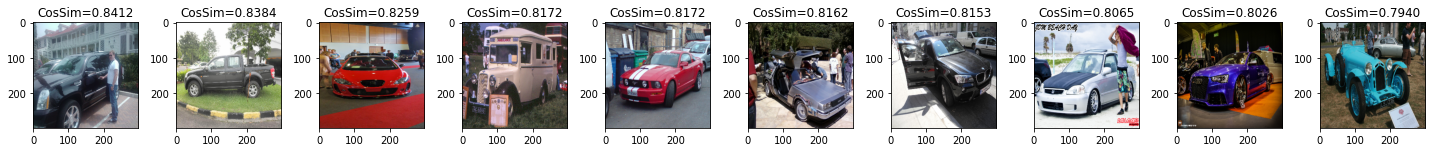



Query Text: A sculpture of a hand wearing a glove 


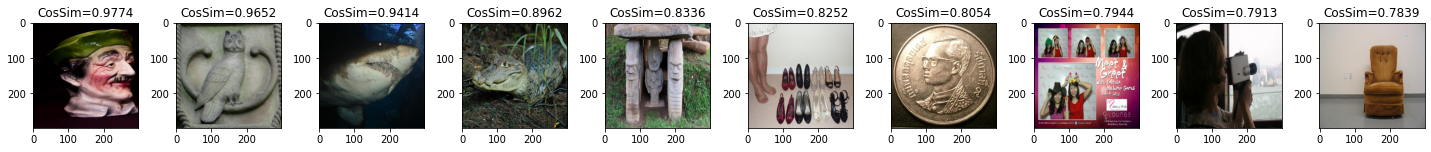



Query Text: An hamster holding a metal rod in its cage 


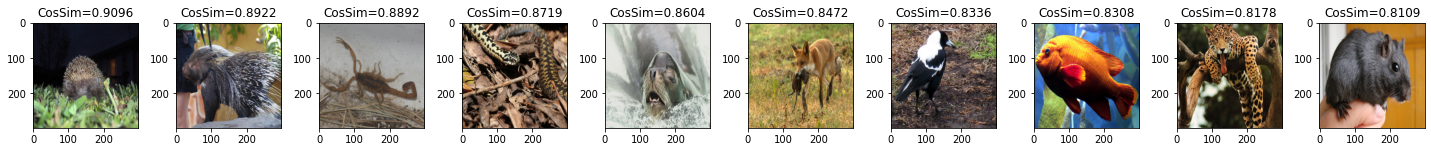



Query Text: A girl wearing SCUBA equipment swimming in a pool.


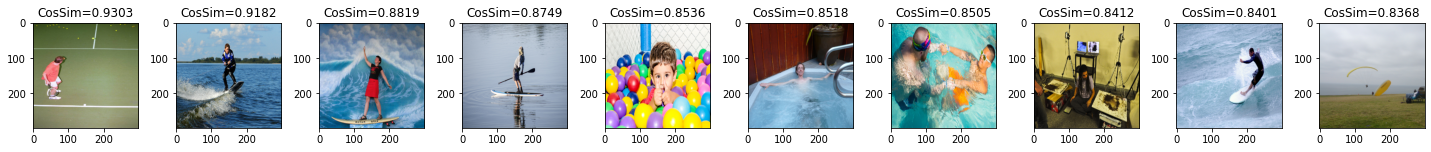



Query Text: A white wall and plug outlet displayed. 


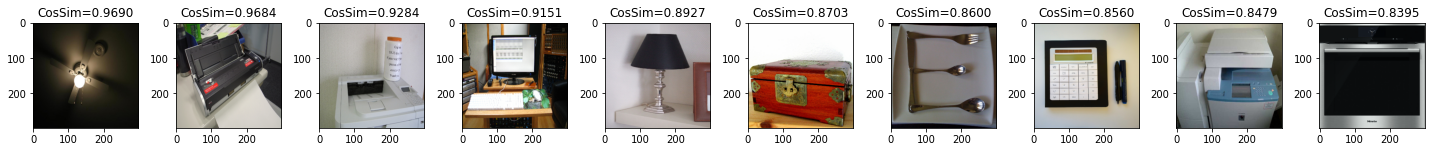

In [48]:
ImageFromText(sim_mat)

Image-Text pairs from Training Data


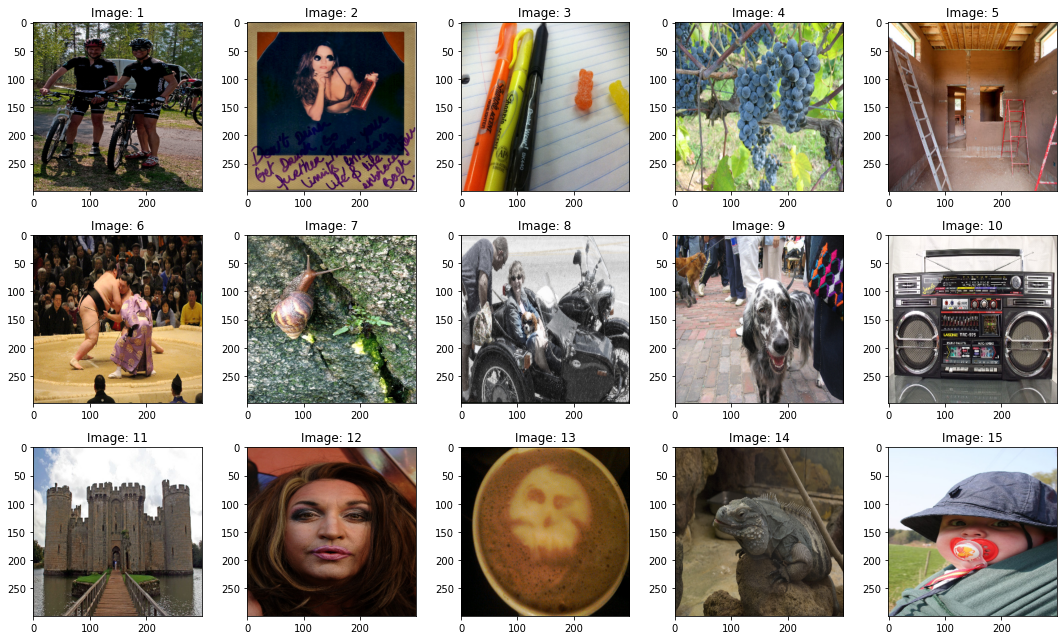

Text: 1 | negative : several people running and walking on treadmills facing windows
Text: 2 | negative : People wearing helmets jumping bicycles over a dirt mound
Text: 3 | negative : A man wearing a helmet attempts a stunt on his bicycle. 
Text: 4 | negative : A bag of buttery popcorn is sitting on a persons lap.
Text: 5 | negative : Men in Detroit tigers uniforms standing talking together.
Text: 6 | negative : A caterpillar is perched on the green leaf.
Text: 7 | negative : A man in a wetsuit and goggles is running.
Text: 8 | negative : a woman in a sparkly red dress witha white furry scarf 
Text: 9 | negative : The black scarf added just the right touch to her outfit.
Text: 10 | positive : An older boxy style cassette deck player. 
Text: 11 | positive : A bridge leads to a grand castle surrounded by water.
Text: 12 | positive : A person with a lot of eye makeup and pink lipstick. 
Text: 13 | negative : Two men standing near and examining a camera. 
Text: 14 | negative : A woman in 

In [56]:
# Dataset Sanity Check
def show15trainingsamples(batch):
    label_dic = {1: "positive", -1: "negative"}
    plt.figure(figsize=(15, 9))
    for i in range(15):
        if i < len(batch["labels"]):
            plt.subplot(3, 5, i + 1)
            img = train_images[batch["image_idx"][i]]
            img = np.flip(img, axis=-1)
            plt.imshow(img)
            plt.title("Image: " + str(i + 1))
    plt.tight_layout()
    plt.show()
    for i in range(15):
        if i < len(batch["labels"]):
            label = int(batch["labels"][i].cpu().numpy().tolist())
            print("Text: " + str(i + 1) + " | " + label_dic[label] + " : " + train_texts[batch["text_idx"][i]])

print("Image-Text pairs from Training Data")
for batch in trainloader:
    show15trainingsamples(batch)
    break

Image-Text pairs from Test Data


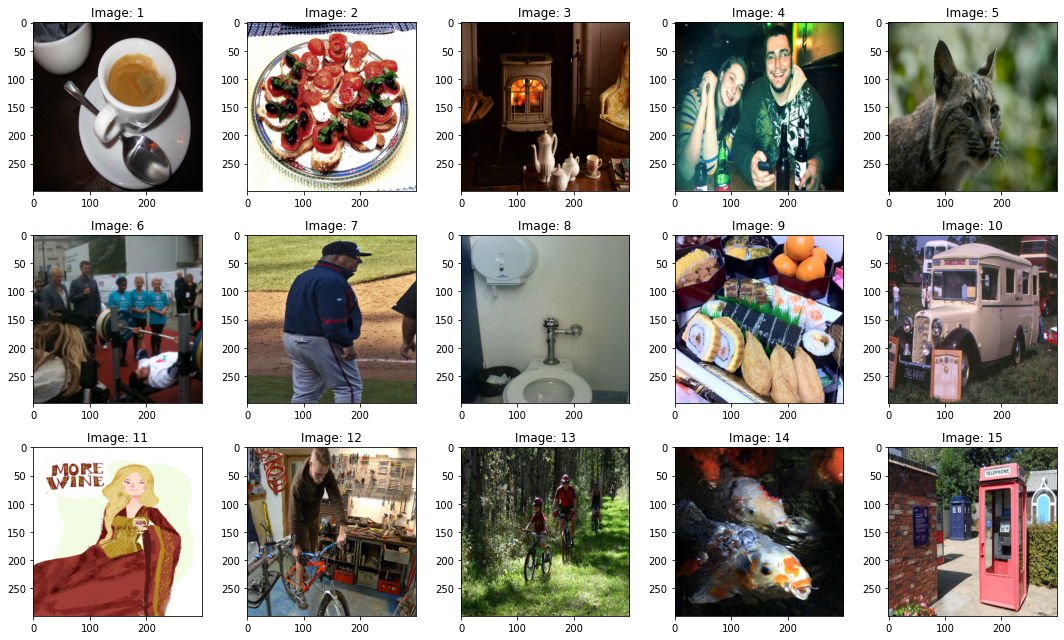

Text: 1 | negative : A girl wearing a white helmet is in the pool with an orange ball in her hand.
Text: 2 | negative : Ladies wearing helmet and sport wear sliding on a roller skates 
Text: 3 | negative : bicycle wheel man sculpture wheel street on the road
Text: 4 | positive : Man and woman sitting at a table having a beer.
Text: 5 | negative : The building with brown door, has two large trees or plants on each side of the door.
Text: 6 | negative : Tongs, a knife and a spatula lined up on a table.
Text: 7 | positive : A man wearing a black hat and blue jacket.
Text: 8 | negative : Several apples of varying ripeness hang on a tree. 
Text: 9 | negative : Two men standing beside a limousine that is in front of a building.
Text: 10 | negative : A woman eating vanilla ice cream in a waffle cone.
Text: 11 | positive : A woman with blonde hair and red dress holding a golden cup.
Text: 12 | negative : A chinchilla lies in a cage and grabs a bar with its little hand.
Text: 13 | negative : Bo

In [66]:
def show15testsamples(batch):
    label_dic = {1: "positive", -1: "negative"}
    plt.figure(figsize=(15, 9))
    for i in range(15):
        if i < len(batch["labels"]):
            plt.subplot(3, 5, i + 1)
            img = test_images[batch["image_idx"][i]]
            img = np.flip(img, axis=-1)
            plt.imshow(img)
            plt.title("Image: " + str(i + 1))
    plt.tight_layout()
    plt.show()
    for i in range(15):
        if i < len(batch["labels"]):
            label = int(batch["labels"][i].cpu().numpy().tolist())
            print("Text: " + str(i + 1) + " | " + label_dic[label] + " : " + test_texts[batch["text_idx"][i]])

print("Image-Text pairs from Test Data")
for batch in testloader:
    show15testsamples(batch)
    break